# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [14]:
import io
import os
import numpy as np
import scipy

In [15]:
PATH_TO_DATA = r"C:\Users\dell\Desktop\MVA\deeplearning\MP2\nlp_project\data"

# 1) Monolingual (English) word embeddings 

In [16]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f) #skip the header
            for i, line in enumerate(f):#enumerate over lines of the file + counter : i
                word, vec = line.split(' ', 1)  # list of two elements the first is assigned to word and the second to vec
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        scores=[]
        indexes_retained=[]
        for key in self.word2vec:
            if key==w:
                scores.append(0)
            else:
                scores.append(self.score(w,key))
        indexes_retained=np.argsort(scores)[-1*K:]     #find the index of the 5 biggest elements of scores
        s=1
        for i in indexes_retained[::-1]:
            print('rank',s,[*self.word2vec][i])
            s+=1
            
    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        return np.dot(self.word2vec[w1],self.word2vec[w2])/(np.linalg.norm(self.word2vec[w1])*np.linalg.norm(self.word2vec[w2]))


In [17]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=150000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1),'\n')

Loaded 150000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
rank 1 cats
rank 2 kitty
rank 3 kitten
rank 4 feline
rank 5 kitties
None 

rank 1 dogs
rank 2 puppy
rank 3 Dog
rank 4 doggie
rank 5 canine
None 

rank 1 dog
rank 2 pooches
rank 3 Dogs
rank 4 doggies
rank 5 canines
None 

rank 1 france
rank 2 Paris
rank 3 parisian
rank 4 london
rank 5 berlin
None 

rank 1 austria
rank 2 europe
rank 3 german
rank 4 berlin
rank 5 poland
None 



In [18]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    
        
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        keys = list(self.w2v.word2vec.keys())
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                
                sentemb.append(np.mean([self.w2v.word2vec[w] for w in sent if w in keys],
                                       axis=0))
                #assert False, 'TODO: fill in the blank'
            else:
                # idf-weighted mean of word vectors
                
                vec = np.sum([idf1[w]*self.w2v.word2vec[w] for w in sent if w in keys],
                             axis=0)/np.sum([idf1[w] for w in sent if w in keys])
                sentemb.append(vec)
                #assert False, 'TODO: fill in the blank'
        return np.vstack(sentemb)
   
    
    def most_similar(self, s,sentences,idf=False, K=5):
        # get most similar sentences and **print** them
        scores=[]
        indexes_retained=[]
        for sent in sentences:
            if sent==s:
                scores.append(0)
            else:
                scores.append(self.score(s,sent,idf))
        indexes_retained=np.argsort(scores)[-1*K:]     #find the index of the 5 biggest elements of scores
        s=1
        for i in indexes_retained[::-1]:
            print('rank',s,sentences[i])
            s+=1

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        enc1=self.encode([s1],idf)
        enc2=self.encode([s2],idf)
        return (np.dot(enc1,enc2.T)/(np.linalg.norm(enc1)*np.linalg.norm(enc2)))[0][0]
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        
        for word in idf:
            idf[word]= max(1,np.log10(len(sentences) / (idf[word])))
        return idf
    

In [19]:
#w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-1M.vec'), nmax=500000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with open('data/sentences.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split() 
        #striping white spaces from the end of s<entences and splitting them to lists by whitespace
        sentences.append(sent) #append list representing the sentence to the list sentences containing all sentences
print('Found %s sentences' % len(sentences))

# Build idf scores for each word
idf1 =s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
import time
x=time.time()
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))
y=(time.time()-x)
print(y)

Found 150736 sentences
0.5726258859719605
0.012930870056152344


In [20]:
y*len(sentences)

1949.1476287841797

In [21]:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean

rank 1 ['an', 'african', 'american', 'man', 'smiling', '.']
rank 2 ['a', 'little', 'african', 'american', 'boy', 'and', 'girl', 'looking', 'up', '.']
rank 3 ['an', 'afican', 'american', 'woman', 'standing', 'behind', 'two', 'small', 'african', 'american', 'children', '.']
rank 4 ['an', 'african', 'american', 'man', 'is', 'sitting', '.']
rank 5 ['a', 'girl', 'in', 'black', 'hat', 'holding', 'an', 'african', 'american', 'baby', '.']


In [22]:
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf=True)


0.47514508753687823

In [23]:
s2v.most_similar('' if not sentences else sentences[10], sentences, idf=True)  # BoV-idf

rank 1 ['an', 'african', 'american', 'man', 'smiling', '.']
rank 2 ['an', 'african', 'american', 'man', 'is', 'sitting', '.']
rank 3 ['a', 'little', 'african', 'american', 'boy', 'and', 'girl', 'looking', 'up', '.']
rank 4 ['an', 'afican', 'american', 'woman', 'standing', 'behind', 'two', 'small', 'african', 'american', 'children', '.']
rank 5 ['a', 'girl', 'in', 'black', 'hat', 'holding', 'an', 'african', 'american', 'baby', '.']


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [3]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
nmax = 50000
word2vec_eng = {}
with io.open('./data/wiki.en.vec', encoding='utf-8') as f:
    next(f)
    for i, line in enumerate(f):
        word, vec = line.split(' ', 1)
        word2vec_eng[word] = np.fromstring(vec, sep=' ')
        if i == (nmax - 1):
            break
    print('Loaded %s english pretrained word vectors' % (len(word2vec_eng)))
    
word2vec_fr = {}
with io.open('./data/wiki.fr.vec', encoding='utf-8') as f:
    next(f)
    for i, line in enumerate(f):
        word, vec = line.split(' ', 1)
        word2vec_fr[word] = np.fromstring(vec, sep=' ')
        if i == (nmax - 1):
            break     
    print('Loaded %s french pretrained word vectors' % (len(word2vec_fr)))    

Loaded 50000 english pretrained word vectors
Loaded 50000 french pretrained word vectors


In [4]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
identical_words = []
keys_eng = set(word2vec_eng.keys())
keys_fr = set(word2vec_fr.keys())
for word in word2vec_eng:
    if word in word2vec_fr:
        identical_words.append(word)
X = []
Y = []
for word in identical_words:
    X.append(word2vec_eng[word])
    Y.append(word2vec_fr[word])
X,Y = np.array(X),np.array(Y)

In [5]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
R = np.dot(Y,X.T)
U, S, V = np.linalg.svd(R) 
W = np.dot(U,V)

In [13]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
M = np.dot(W,X)

def nearest_neighbors_eng(M,Y,french_word,identical_words,K=5):
    scores=[]
    i= identical_words.index(french_word)
    vec = M[i]
    for x in list(Y):
        scores.append(np.dot(x,vec)/(np.linalg.norm(x)*np.linalg.norm(vec)))
    indexes_retained=np.argsort(scores)[-1*K:]  
    return [identical_words[i] for i in indexes_retained[::-1]]

print('the nearest english words to the french word place are',nearest_neighbors_eng(M,Y,'place',identical_words))
print('the nearest english words to the french word automobile are',nearest_neighbors_eng(M,Y,'automobile',identical_words))
print('the nearest english words to the french word population are',nearest_neighbors_eng(M,Y,'population',identical_words))
print('the nearest english words to the french word article are',nearest_neighbors_eng(M,Y,'article',identical_words))

the nearest english words to the french word place are ['place', 'position', 'places', 'part', 'mis']
the nearest english words to the french word automobile are ['automobile', 'automobiles', 'moto', 'automotive', 'bugatti']
the nearest english words to the french word population are ['population', 'populations', 'hab', '/km²', 'km²']
the nearest english words to the french word article are ['article', 'articles', 'admissible', 'interwiki', 'page']


In [19]:
def nearest_neighbors_fr(M,Y,eng_word,identical_words,K=5):
    scores=[]
    i= identical_words.index(eng_word)
    vec = Y[i]
    for x in list(M):
        scores.append(np.dot(x,vec)/(np.linalg.norm(x)*np.linalg.norm(vec)))
    indexes_retained=np.argsort(scores)[-1*K:]  
    return [identical_words[i] for i in indexes_retained[::-1]]

print('the nearest french words to the english word place are',nearest_neighbors_fr(M,Y,'place',identical_words))
print('the nearest french words to the english word car are',nearest_neighbors_fr(M,Y,'car',identical_words))
print('the nearest french words to the english word population are',nearest_neighbors_fr(M,Y,'population',identical_words))
print('the nearest french words to the english word article are',nearest_neighbors_fr(M,Y,'article',identical_words))
print('the nearest french words to the english word food are',nearest_neighbors_fr(M,Y,'food',identical_words))

the nearest french words to the english word place are ['place', 'position', 'places', 'billboard', 'chart']
the nearest french words to the english word car are ['car', 'mais', 'pas', 'si', 'ne']
the nearest french words to the english word population are ['population', 'populations', '/km²', 'km²', 'proportion']
the nearest french words to the english word article are ['article', 'articles', 'pertinent', 'admissible', 'page']
the nearest french words to the english word food are ['food', 'foods', 'nutrition', 'health', 'drug']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [24]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
train_sentences = []
train_labels = []
path = './data/SST/stsa.fine.train'
with io.open(path, encoding='utf-8') as f:
    for line in f:
        label, sent = line.split(' ', 1)
        train_sentences.append(sent.rstrip().split())
        train_labels.append(int(label))
    
dev_sentences = []
dev_labels = []
path = './data/SST/stsa.fine.dev'
with io.open(path, encoding='utf-8') as f:
    for line in f:
        label, sent = line.split(' ', 1)
        dev_sentences.append(sent.rstrip().split())
        dev_labels.append(int(label))
        
test_sentences = []
path = './data/SST/stsa.fine.test.X'
with io.open(path, encoding='utf-8') as f:
    for line in f:
        test_sentences.append(line.rstrip().split())

In [26]:
# 2 - Encode sentences with the BoV model above
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=150000)
s2v = BoV(w2v)
# TYPE CODE HERE
 # BoV-mean
train_bov_mean = s2v.encode(train_sentences)
dev_bov_mean = s2v.encode(dev_sentences)
test_bov_mean = s2v.encode(test_sentences)
 # BoV-idf
idf1 = s2v.build_idf(train_sentences+dev_sentences+test_sentences)
train_bov_idf = s2v.encode(train_sentences,idf=True)
dev_bov_idf = s2v.encode(dev_sentences,idf=True)
test_bov_idf = s2v.encode(test_sentences,idf=True)

Loaded 150000 pretrained word vectors


In [49]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
from sklearn.linear_model import LogisticRegression
C = [0.001,0.01,0.05,0.1,0.5,1,3,10,20,30,40,50,60,70,80,90,100] # regularization strengths
scores = []
for c in C:
    logReg = LogisticRegression(penalty='l2',C = c)
    logReg.fit(train_bov_mean,train_labels)
    score = logReg.score(dev_bov_mean,dev_labels)
    scores.append(score)
    
index_best_score=np.argmax(scores)
print('The best score on dev set when using mean BoV is : ',round(scores[index_best_score]*100,2),'% \
and is given by given by a regularization parameter C = ',C[index_best_score])

logReg = LogisticRegression(penalty='l2',C = C[index_best_score])
logReg.fit(train_bov_mean,train_labels)
score = logReg.score(train_bov_mean,train_labels)
print('The training score using the average of word vectors is: ',round(score*100,2),'%')

C = [0.001,0.01,0.05,0.1,0.5,1,3,10,20,30,40,50,60,70,80,90,100] # regularization strengths
scores = []
for c in C:
    logReg = LogisticRegression(penalty='l2',C = c)
    logReg.fit(train_bov_idf,train_labels)
    score = logReg.score(dev_bov_idf,dev_labels)
    scores.append(score)
    
index_best_score=np.argmax(scores)
print('The best score on dev set when using weighted average is : ',round(scores[index_best_score]*100,2),'% \
and is given by given by a regularization parameter C = ',C[index_best_score])

logReg = LogisticRegression(penalty='l2',C = C[index_best_score])
logReg.fit(train_bov_idf,train_labels)
score = logReg.score(train_bov_idf,train_labels)
print('The training score using the weighted-average is: ',round(score*100,2),'%')


The best score on dev set when using mean BoV is :  42.87 % and is given by given by a regularization parameter C =  3
The training score using the average of word vectors is:  48.53 %
The best score on dev set when using weighted average is :  43.23 % and is given by given by a regularization parameter C =  1
The training score using the weighted-average is:  47.6 %


In [42]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
path = './logreg_bov_y_test_sst.txt'
output_file = open(path, 'w')
logReg = LogisticRegression(penalty='l2',C = 3)
logReg.fit(train_bov_mean,train_labels)
predictions = logReg.predict(test_bov_mean)
for i in range(len(predictions)):
    output_file.write("%s\n" % predictions[i])
output_file.close()

In [43]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)
from numpy.core.umath_tests import inner1d
# TYPE CODE HERE
from sklearn.ensemble import RandomForestClassifier
path = './RFC_bov_y_test_sst.txt'
output_file = open(path, 'w')
rfc=RandomForestClassifier(max_depth=3, n_estimators=10)
rfc.fit(train_bov_mean,train_labels)
predictions = rfc.predict(test_bov_mean)
for i in range(len(predictions)):
    output_file.write("%s\n" % predictions[i])
output_file.close()
print(rfc.score(train_bov_idf,train_labels))
print(rfc.score(dev_bov_mean,dev_labels))

0.3669241573033708
0.35603996366939145


In [28]:
from sklearn.svm import SVC
path = './SVC_bov_y_test_sst.txt'
output_file = open(path, 'w')
clf = SVC(C=200)
clf.fit(train_bov_mean,train_labels)
clf.score(dev_bov_mean,dev_labels)
predictions = clf.predict(test_bov_mean)
for i in range(len(predictions)):
    output_file.write("%s\n" % predictions[i])
output_file.close()

c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.4359673024523161

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [38]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation,Dropout

In [31]:
# 1 - Load train/dev/test sets of SST


# TYPE CODE HERE
def load_data_sent(filename, test=False):
    sentences = []
    labels = []
    with io.open(filename, encoding='utf-8') as f:
        for line in f:
            if not test:
                label, line = line.split(' ', 1)
                labels.append(label)
            sentences.append(line.rstrip())
    
    return sentences, labels
PATH='data/SST/'

In [32]:
sst_test, _ = load_data_sent(os.path.join(PATH, 'stsa.fine.test.X'), True)
sst_dev, sst_dev_label = load_data_sent(os.path.join(PATH, 'stsa.fine.dev'))
sst_train, sst_train_label = load_data_sent(os.path.join(PATH, 'stsa.fine.train'))

In [33]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing.text import text_to_word_sequence, one_hot

def get_vocsize(*args):
    r = []    
    for a in args:
        for e in a:
            words = text_to_word_sequence(e) #spliting sent to words
            for w in words:
                r.append(w)            
    return len(list(set(r)))
#one hot encoding all sentences
def text_to_num(n, *args):
    r = []    
    for a in args:
        data = []
        for e in a:
            data.append(one_hot(e, n))        
        r.append(data)    
    return np.array(r[0]), np.array(r[1]), np.array(r[2])

n = get_vocsize(sst_test, sst_dev, sst_train)
X_train, X_dev, X_test = text_to_num(n, sst_train, sst_dev, sst_test)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [36]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train)
X_dev = pad_sequences(X_dev)
X_test = pad_sequences(X_test)

## 4.2 - Design and train your model

In [77]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW



embed_dim  = 64  # word embedding dimension
nhid       = 32  # number of hidden units in the LSTM
vocab_size = n  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))

In [78]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 64)          1141696   
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 1,154,277
Trainable params: 1,154,277
Non-trainable params: 0
_________________________________________________________________


In [79]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 64)          1141696   
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 1,154,277
Trainable params: 1,154,277
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64

n_epochs = 20
y_train = np_utils.to_categorical(train_labels)
y_dev = np_utils.to_categorical(dev_labels)

history = model.fit(X_train, y_train, batch_size=bs,epochs=n_epochs,validation_data=(X_dev, y_dev),verbose=0)

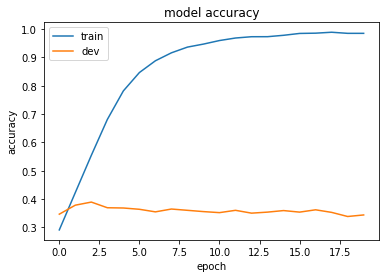

In [81]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.savefig('train_dev_evol.png')
plt.show()

In [76]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
path = './logreg_lstm_y_test_sst.txt'
thefile = open(path, 'w')
predictions = model.predict_classes(X_test)
for i in range(len(predictions)):
    thefile.write("%s\n" % predictions[i])
thefile.close()

## 4.3 -- innovate !

## Using pretrained embeddings

In [53]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

def get_voc(*args):
    """
        Args:
            *args (lists of strings): list of the strings of the training/dev/testing dataset
        Returns:
            list: a list containing all the words (unique)
    """
    r = []
    
    for a in args:
        for e in a:
            words = text_to_word_sequence(e)
            for w in words:
                r.append(w)
                
    uniq_word = list(set(r)) # set use to discard duplicates
    
    return {w: None for w in uniq_word}

def word_to_embeddings(filename, *args):
    voca = get_voc(*args)
    w2e = {}
    
    max_size = len(voca)
    counter = 0
    with io.open(filename, encoding='utf-8') as f:
        next(f) # to skip the header
        for line in f:
            if counter == max_size:
                break
            word, vec = line.split(' ', 1)
            if word.strip().lower() in voca:
                w2e[word] = np.fromstring(vec, sep=' ')
                counter += 1
    
    return w2e

# take 20 seconds on my computer...
w2v_dict = word_to_embeddings(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), sst_test, sst_dev, sst_train)

In [54]:
vocabulaire = set(get_voc(sst_test, sst_dev, sst_train)) # voc from the SST files
voca_w2v = set(w2v_dict.keys()) # voc using word_2_vec from wikipedia

In [66]:
def getEmbeddings(voc_list):
    """
        Args:
            voc_list (list): list of unique words extracted from all questions
        Returns:
            embeddings (ndarray): A matrix of shape (vocabulary size, embeddings_size)
    """
    embeddings = np.zeros((len(voc_list), 300))
    for i, w in enumerate(voc_list):
        if w in w2v_dict.keys():
            embeddings[i] = w2v_dict[w]
        else: embeddings[i]=300*[0]
    return embeddings

In [67]:
vocab = list(get_voc(sst_test, sst_dev, sst_train))
embedding_matrix = getEmbeddings(vocab)

# need to transform X_test, X_train, X_dev into matrix of idx of word in embedding_matrix
def preprocess_matrix(X, vocab, max_len):
    vocab = {k: i for i, k in enumerate(vocab)}
    new_X = np.zeros((len(X), max_len), dtype=int)
    
    for i, e in enumerate(X):
        w_list = text_to_word_sequence(e)
        size = len(w_list)
        for j, w in enumerate(w_list):
            new_X[i,max_len-size+j] = vocab[w]
            
    return new_X

# sst_test, sst_dev, sst_train
new_X_test = preprocess_matrix(sst_test, vocab, max_len=52)
new_X_train = preprocess_matrix(sst_train, vocab, max_len=52)
new_X_dev = preprocess_matrix(sst_dev, vocab, max_len=52)

In [69]:
from keras.layers import Input
from keras.models import Model

In [86]:
voc_size = embedding_matrix.shape[0]
word2vec_dim = embedding_matrix.shape[1]
max_len = 52 #maximum number of word in a string 
activation = 'tanh'
q_hidden_units = 64
merge_hidden_units = 50


_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(
        input_dim=voc_size,
        output_dim=word2vec_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False,
        mask_zero=False
    )(_input)

lstm = LSTM(q_hidden_units, return_sequences=False)(embedded)
probabilities = Dense(5, activation='softmax')(lstm)
model2 = Model(input=[_input], output=probabilities)
model2.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
model2.summary()

c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 52)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 52, 300)           5351700   
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 5,445,465
Trainable params: 93,765
Non-trainable params: 5,351,700
_________________________________________________________________


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


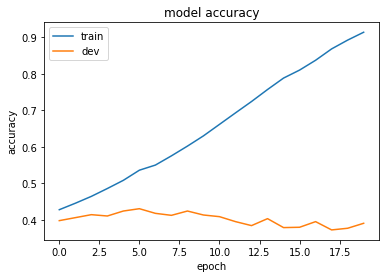

In [88]:
history=model2.fit(new_X_train, y_train, batch_size=bs,validation_data=(new_X_dev, y_dev),epochs=20,verbose=0)

print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.savefig('train_dev_evol_2.png')
plt.show()

In [89]:
# - Generate your predictions on the test set using model.predict(x_test)


# TYPE CODE HERE
path = './pretrained-embeddings_lstm_y_test_sst.txt'
thefile = open(path, 'w')
predictions = better_model.predict(X_test)
for i in range(len(predictions)):
    thefile.write("%s\n" % np.argmax(predictions[i]))
thefile.close()